In [1]:
import os
import pandas_datareader as pdr
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
NVDA = pdr.get_data_tiingo('NVDA',api_key = os.getenv('api_key'))
NVDA.tail()

/var/folders/lw/6vvkjf6919ndmlnqfvwpynlh0000gn/T/ipykernel_16903/4261337285.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  NVDA = pdr.get_data_tiingo('NVDA',api_key = os.getenv('api_key'))


close     high     low    open     volume  \
symbol date                                                                    
NVDA   2025-03-07 00:00:00+00:00  112.69  113.480  107.56  111.25  341755468   
       2025-03-10 00:00:00+00:00  106.98  111.850  105.46  109.90  361107562   
       2025-03-11 00:00:00+00:00  108.76  112.236  104.77  106.99  354865692   
       2025-03-12 00:00:00+00:00  115.74  116.760  112.88  114.12  323857454   
       2025-03-13 00:00:00+00:00  115.58  117.760  113.79  117.03  299033131   

                                    adjClose     adjHigh      adjLow  \
symbol date                                                            
NVDA   2025-03-07 00:00:00+00:00  112.680264  113.470196  107.550708   
       2025-03-10 00:00:00+00:00  106.970758  111.840337  105.450889   
       2025-03-11 00:00:00+00:00  108.750604  112.226304  104.760949   
       2025-03-12 00:00:00+00:00  115.740000  116.760000  112.880000   
       2025-03-13 00:00:00+00:00  115.580000  117.760000  113.790000   

                                     adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                    
NVDA   2025-03-07 00:00:00+00:00  111.240389  341755468     0.00          1.0  
       2025-03-10 00:00:00+00:00  109.890505  361107562     0.00          1.0  
       2025-03-11 00:00:00+00:00  106.980757  354865692     0.00          1.0  
       2025-03-12 00:00:00+00:00  114.120000  323857454     0.01          1.0  
       2025-03-13 00:00:00+00:00  117.030000  299033131     0.00          1.0

In [2]:
# 資料預處理，取近300天的資料

NVDA_adj=NVDA.iloc[:,5:9] 
NVDA_adj.columns = ['Close', 'High', 'Low', 'Open'] 
NVDA_adj = NVDA_adj.reset_index() #從多index變成單一index
NVDA_adj.index = NVDA_adj['date'] # 將index設為date
NVDA_adj = NVDA_adj.iloc[-300:,2:6] 
NVDA_adj_20 = pd.DataFrame(NVDA_adj)
NVDA_adj_20

,Close,High,Low,Open
date,,,,
2024-01-02 00:00:00+00:00,48.148576,49.275122,47.575807,49.224142
2024-01-03 00:00:00+00:00,47.549818,48.164670,47.300918,47.465852
2024-01-04 00:00:00+00:00,47.978645,48.480442,47.488842,47.747738
2024-01-05 00:00:00+00:00,49.077202,49.527020,48.286531,48.442458
2024-01-08 00:00:00+00:00,52.231929,52.253920,49.459048,49.492034
...,...,...,...,...
2025-03-07 00:00:00+00:00,112.680264,113.470196,107.550708,111.240389
2025-03-10 00:00:00+00:00,106.970758,111.840337,105.450889,109.890505
2025-03-11 00:00:00+00:00,108.750604,112.226304,104.760949,106.980757


In [3]:
change = NVDA_adj_20.Close - NVDA_adj_20.Close.shift(1) # 每日股價變動
# 每日上漲幅度
change_up = pd.Series(index=change.index, data=change[change>0])
change_up = change_up.fillna(0)

# 每日下跌幅度 (取正值，加負號)
change_down = pd.Series(index=change.index, data=-change[change<0])
change_down = change_down.fillna(0)


# RSI的計算公式
RSI = 100 × 前N日漲幅的平均值 ÷ ( 前N日漲幅的平均值 + 前N日跌幅的平均值 )

1. 前N日漲幅的平均值 = 前N日跌幅的平均值：把這個條件帶入公式，RSI會等於50，代表這段時間內買盤跟賣盤是差不多的。
2. 前N日漲幅的平均值 < 前N日跌幅的平均值：RSI小於50，代表買盤較賣盤弱。
3. 前N日漲幅的平均值 > 前N日跌幅的平均值：RSI大於50，代表買盤較賣盤強。

N常見值為6, 12, 14, 24

In [5]:
# 以12天為例子
import numpy as np
up_mean = []
down_mean = []
for i in range(13, len(change_up)+1):
    up_mean.append(np.mean(change_up.values[i-12:i]))
    down_mean.append(np.mean(change_down.values[i-12:i]))

In [32]:
# 計算RSI
RSI = []
for i in range(len(up_mean)):
    RSI.append((100 * up_mean[i]/(up_mean[i]+down_mean[i])))
RSI_12_series = pd.Series(index = NVDA_adj_20.Close.index[12:], data = RSI)
RSI_12_series = pd.DataFrame(RSI_12_series)
RSI_12_series = RSI_12_series.rename(columns={0: 'RSI'})
RSI_12_series

,RSI
date,
2024-01-19 00:00:00+00:00,92.240543
2024-01-22 00:00:00+00:00,96.599059
2024-01-23 00:00:00+00:00,96.543074
2024-01-24 00:00:00+00:00,96.645623
2024-01-25 00:00:00+00:00,95.695881
...,...
2025-03-07 00:00:00+00:00,27.065330
2025-03-10 00:00:00+00:00,23.576328
2025-03-11 00:00:00+00:00,28.168056


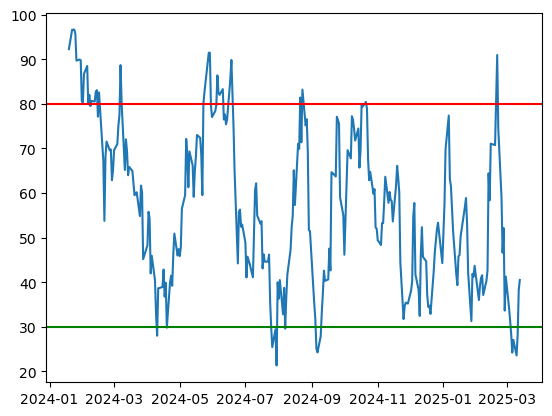

In [34]:
# 由圖可見，小於０買盤較弱，大於０買盤較強

import matplotlib.pyplot as plt

plt.plot(RSI_12_series)
plt.axhline(y=80, color='red')
plt.axhline(y=30, color='green')

由上圖可見，若是觸碰到紅線，就賣出全部，弱勢碰到綠線就買入

In [59]:
# 訊號標籤
signal = []

# 庫存標籤
stock = 0

for i in range(len(RSI)):
    if RSI[i] >=80 and stock == 1:
        stock -= 1
        signal.append(-1)
    elif RSI[i] <=30 and stock ==0:
        stock += 1
        signal.append(1)
    else:
        signal.append(0)

#整理成dataframe
RSI_signal = pd.Series(index = RSI_12_series.index, data = signal)
print(signal)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


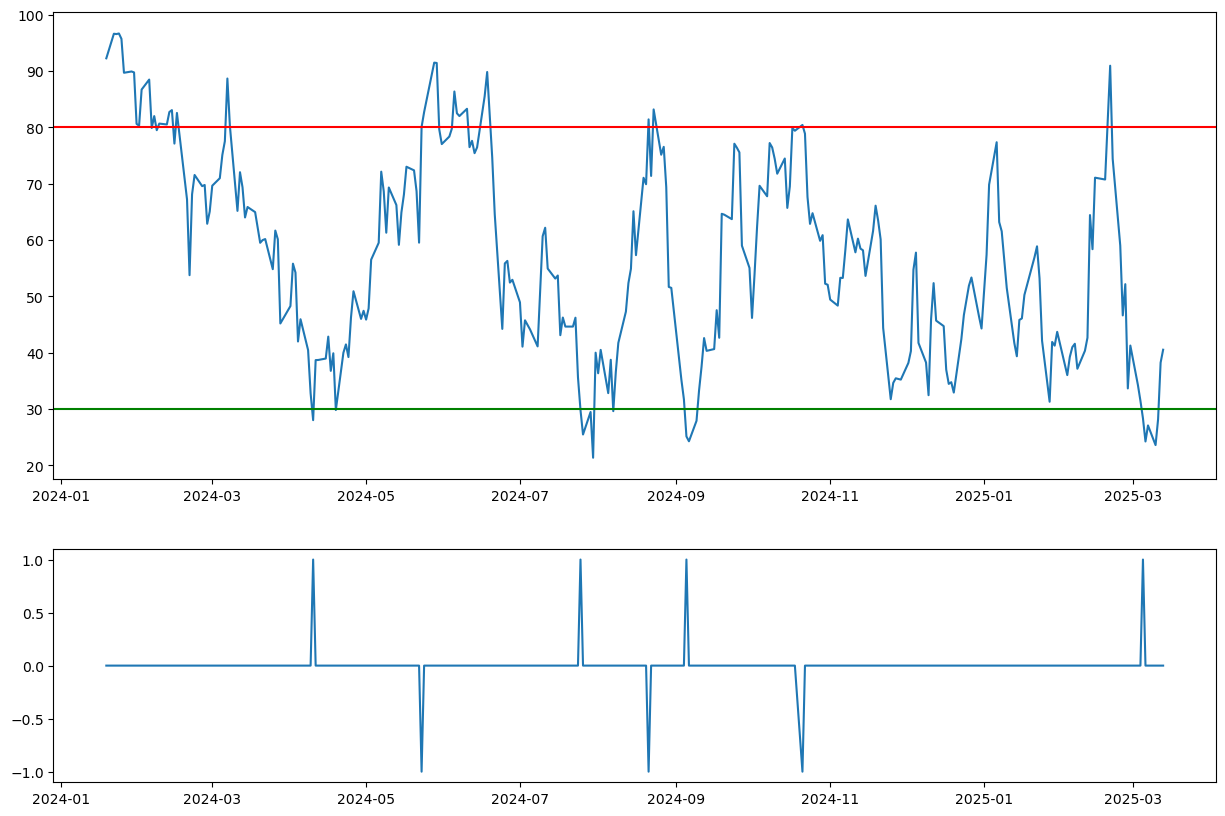

In [61]:
import numpy as np
from matplotlib import gridspec
import pandas as pd

fig = plt.figure(figsize=(15,10))
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# the fisrt subplot
ax0 = plt.subplot(gs[0])
# line0 = ax0.plot(x, y, color='r')
ax0.plot(RSI_12_series)
ax0.axhline(y=80, color='red')
ax0.axhline(y=30, color='green')

#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
RSI_sig = pd.Series(index = RSI_signal.index, data = list(RSI_signal.values))
ax1.plot(RSI_signal)

# 計算投資報酬率

In [89]:
# 因為每次收盤後看到訊號，隔日開盤後才能做買進
Open = NVDA_adj_20.Open

#紀錄每次買賣投資報酬率
return_ratio = []

#庫存股數
stock = 0

# 購買的價格
buy_price = 0

# 賣出的價格
sell_price = 0

# 計算投資報酬率
for i in range(len(signal)):
    if signal[i] == 1: # 訊號大於一，隔天開盤買入
        buy_price = Open[RSI_signal.index[i+1]]
        stock += 1
    elif signal[i] == -1: # 訊號小於一，隔天開盤賣出
        sell_price = Open[RSI_signal.index[i+1]]
        stock -= 1
        return_ratio.append((sell_price-buy_price)/buy_price)
        buy_price = 0 #清除上次買入金額 
        sell_price = 0 #清除上次賣出金額
    else:
        continue


# 總報酬率
total_return = 1
for ret in return_ratio:
    total_return *= (1 + ret)
    
print("總投資報酬率："+str((total_return-1)*100)+'%')

總投資報酬率：76.86805047876784%
